In [1]:
import xarray
import numpy as np
import netCDF4 as nc
import pandas as pd
import geopandas as gpd

from calendar import month_name
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator, LongitudeLocator
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm, ListedColormap

from scipy.io import loadmat
from matplotlib.path import Path
from string import ascii_lowercase

Could not save font_manager cache [Errno 28] No space left on device


In [2]:
def get_map_norm(cmap, levels, no_offset=True):
    """
    Get a discrete colormap and normalization for plotting with matplotlib.
    Set no_offset=False to obtain a colormap that is similar to what xarray.plot() yields.
    """
    nlev = len(levels)
    cmap = plt.cm.get_cmap(cmap, nlev-int(no_offset))
    colors = list(cmap(np.arange(nlev)))
    cmap = ListedColormap(colors, "")
    norm = BoundaryNorm(levels, ncolors=nlev, clip=False)
    return cmap, norm

In [3]:
def plot_map(ncol,clon,clat,lon,lat,var_val,data_src):

    ax = fig.add_subplot(spec[nrow,ncol], projection=proj)

    C = ax.pcolormesh(clon,clat,var_val, transform=ccrs.PlateCarree(),
                      cmap=cmap, norm=norm)
    
    C.cmap.set_under('w')
    
    CS = ax.contour(lon,lat,var_val,levs, colors='k', transform=ccrs.PlateCarree(),zorder=40)
    
    ax.add_feature(cfeature.LAND,color='blanchedalmond',zorder=50)
    ax.coastlines(zorder=50)
            
    # ADDING GRID LINES AND GRID LABELS
    gl = ax.gridlines(draw_labels=True)
    
    gl.xlocator = mticker.FixedLocator([173, -167])
    gl.ylocator = mticker.FixedLocator([54,64])
    
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}
    gl.bottom_labels = False
    gl.top_labels = False

    if ncol>0:
        gl.left_labels = False
        
    if ncol<2:
        gl.right_labels = False
    
    if nrow == 4:
        gl.bottom_labels = True
        
    plt.setp(ax.spines.values(), linewidth=2,zorder=100)
    
     # Titles
    if nrow == 0:
        title_text = data_src
        ax.set_title(title_text, fontsize=28)
    
    # Month Labels
    if ncol == 0:
        plt_lab = month_name[m]   
        ax.text(.03,.88, plt_lab,  fontsize=25, transform=ax.transAxes, 
                ha='left',  va='center', zorder=53)
        
    # Plot labels   
    #ax.text(.95,.88, plot_labels[nlab], fontsize=25, transform=ax.transAxes,
    #        ha='center', va='center', zorder=60) 
    
    # SET AXES EXTENT
    ax.set_extent([lon_min,lon_max,lat_min,66], crs=ccrs.PlateCarree())     
    
    if (nrow == 6) & (ncol == 0):
        pos = ax.get_position()
        cax = fig.add_axes([pos.x0, pos.y0-.3*pos.height, 2*pos.width, .1*pos.height])
        cbar = plt.colorbar(C,cax=cax,orientation='horizontal')
        #cbar.ax.set_xticks(levels[::2])
        cax.plot([levs]*2, [0, 1], 'k')
        cbar.ax.tick_params(labelsize=16)
        cax.set_xlabel('Mean sea ice concentration (%)',fontsize=20)

In [4]:
# NEP Grid
nep_grd_fil = '/work/role.medgrp/NEP/plotting/shared_files/NEP_ocean_static_nomask.nc'
grd_fid = nc.Dataset(nep_grd_fil)

# Extracting tracer lat/lon from the supergrid
nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

# Extracting tracer corner lat/lon from the supergrid - needed for regridding and pcolor plots
nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]

lsm = grd_fid.variables['wet'][:]
lsm[lsm<1]=0 
lsm[lsm>1]=1 

nep_area = grd_fid.variables['areacello'][:].squeeze()
nep_area[lsm<.5]=0

chuk_mask = nep_lat>66

# Model climatology
conc = xarray.open_mfdataset(('/work/role.medgrp/NEP/plotting/Figure_21/nep_siconc_1993-2019_ts.nc'))['siconc']
model_conc = conc.sel(time=slice('1993', '2019')).groupby('time.month').mean('time').load()

plot_labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r']


In [5]:
# Observation Data
obs_mat = loadmat('/work/role.medgrp/NEP/plotting/Figure_21/sic.mat')
nt = len(obs_mat['time'].squeeze())
ny, nx = obs_mat['x'].shape
mask = obs_mat['ifXY'].astype('bool').reshape(-1, order='F')

# Gymnastics to convert from 2D (time, space) with no missing data
# to 3D (time, y, x) with masked missing data
obs_ice = np.zeros((nt, ny*nx)) * np.nan
nused = 0
for i in range(len(mask)):
    if mask[i]:
        obs_ice[:, i] = obs_mat['data'][nused, :]
        nused += 1
obs_ice = xarray.DataArray(
    obs_ice.reshape((nt, ny, nx), order='F'), 
    dims=['time', 'y', 'x'], 
     coords={
        'time': pd.date_range('1979-01', freq='1MS', periods=nt),})

# Same for ice area
obs_area = np.zeros((ny*nx)) * np.nan
nused = 0
for i in range(len(mask)):
    if mask[i]:
        obs_area[i] = obs_mat['w'][nused, 0]
        nused += 1
obs_area = xarray.DataArray(
obs_area.reshape((ny, nx), order='F'), dims=['y', 'x'], )

# Observed climatology
obs_conc = obs_ice.sel(time=slice('1993', '2019')).groupby('time.month').mean('time')
obs_lon = obs_mat['x']
obs_lon[obs_lon<0] = obs_lon[obs_lon<0]+360
obs_lat = obs_mat['y']

/vftmp/Utheri.Wagura/pid68683/ipykernel_85406/4131494823.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap, nlev-int(no_offset))


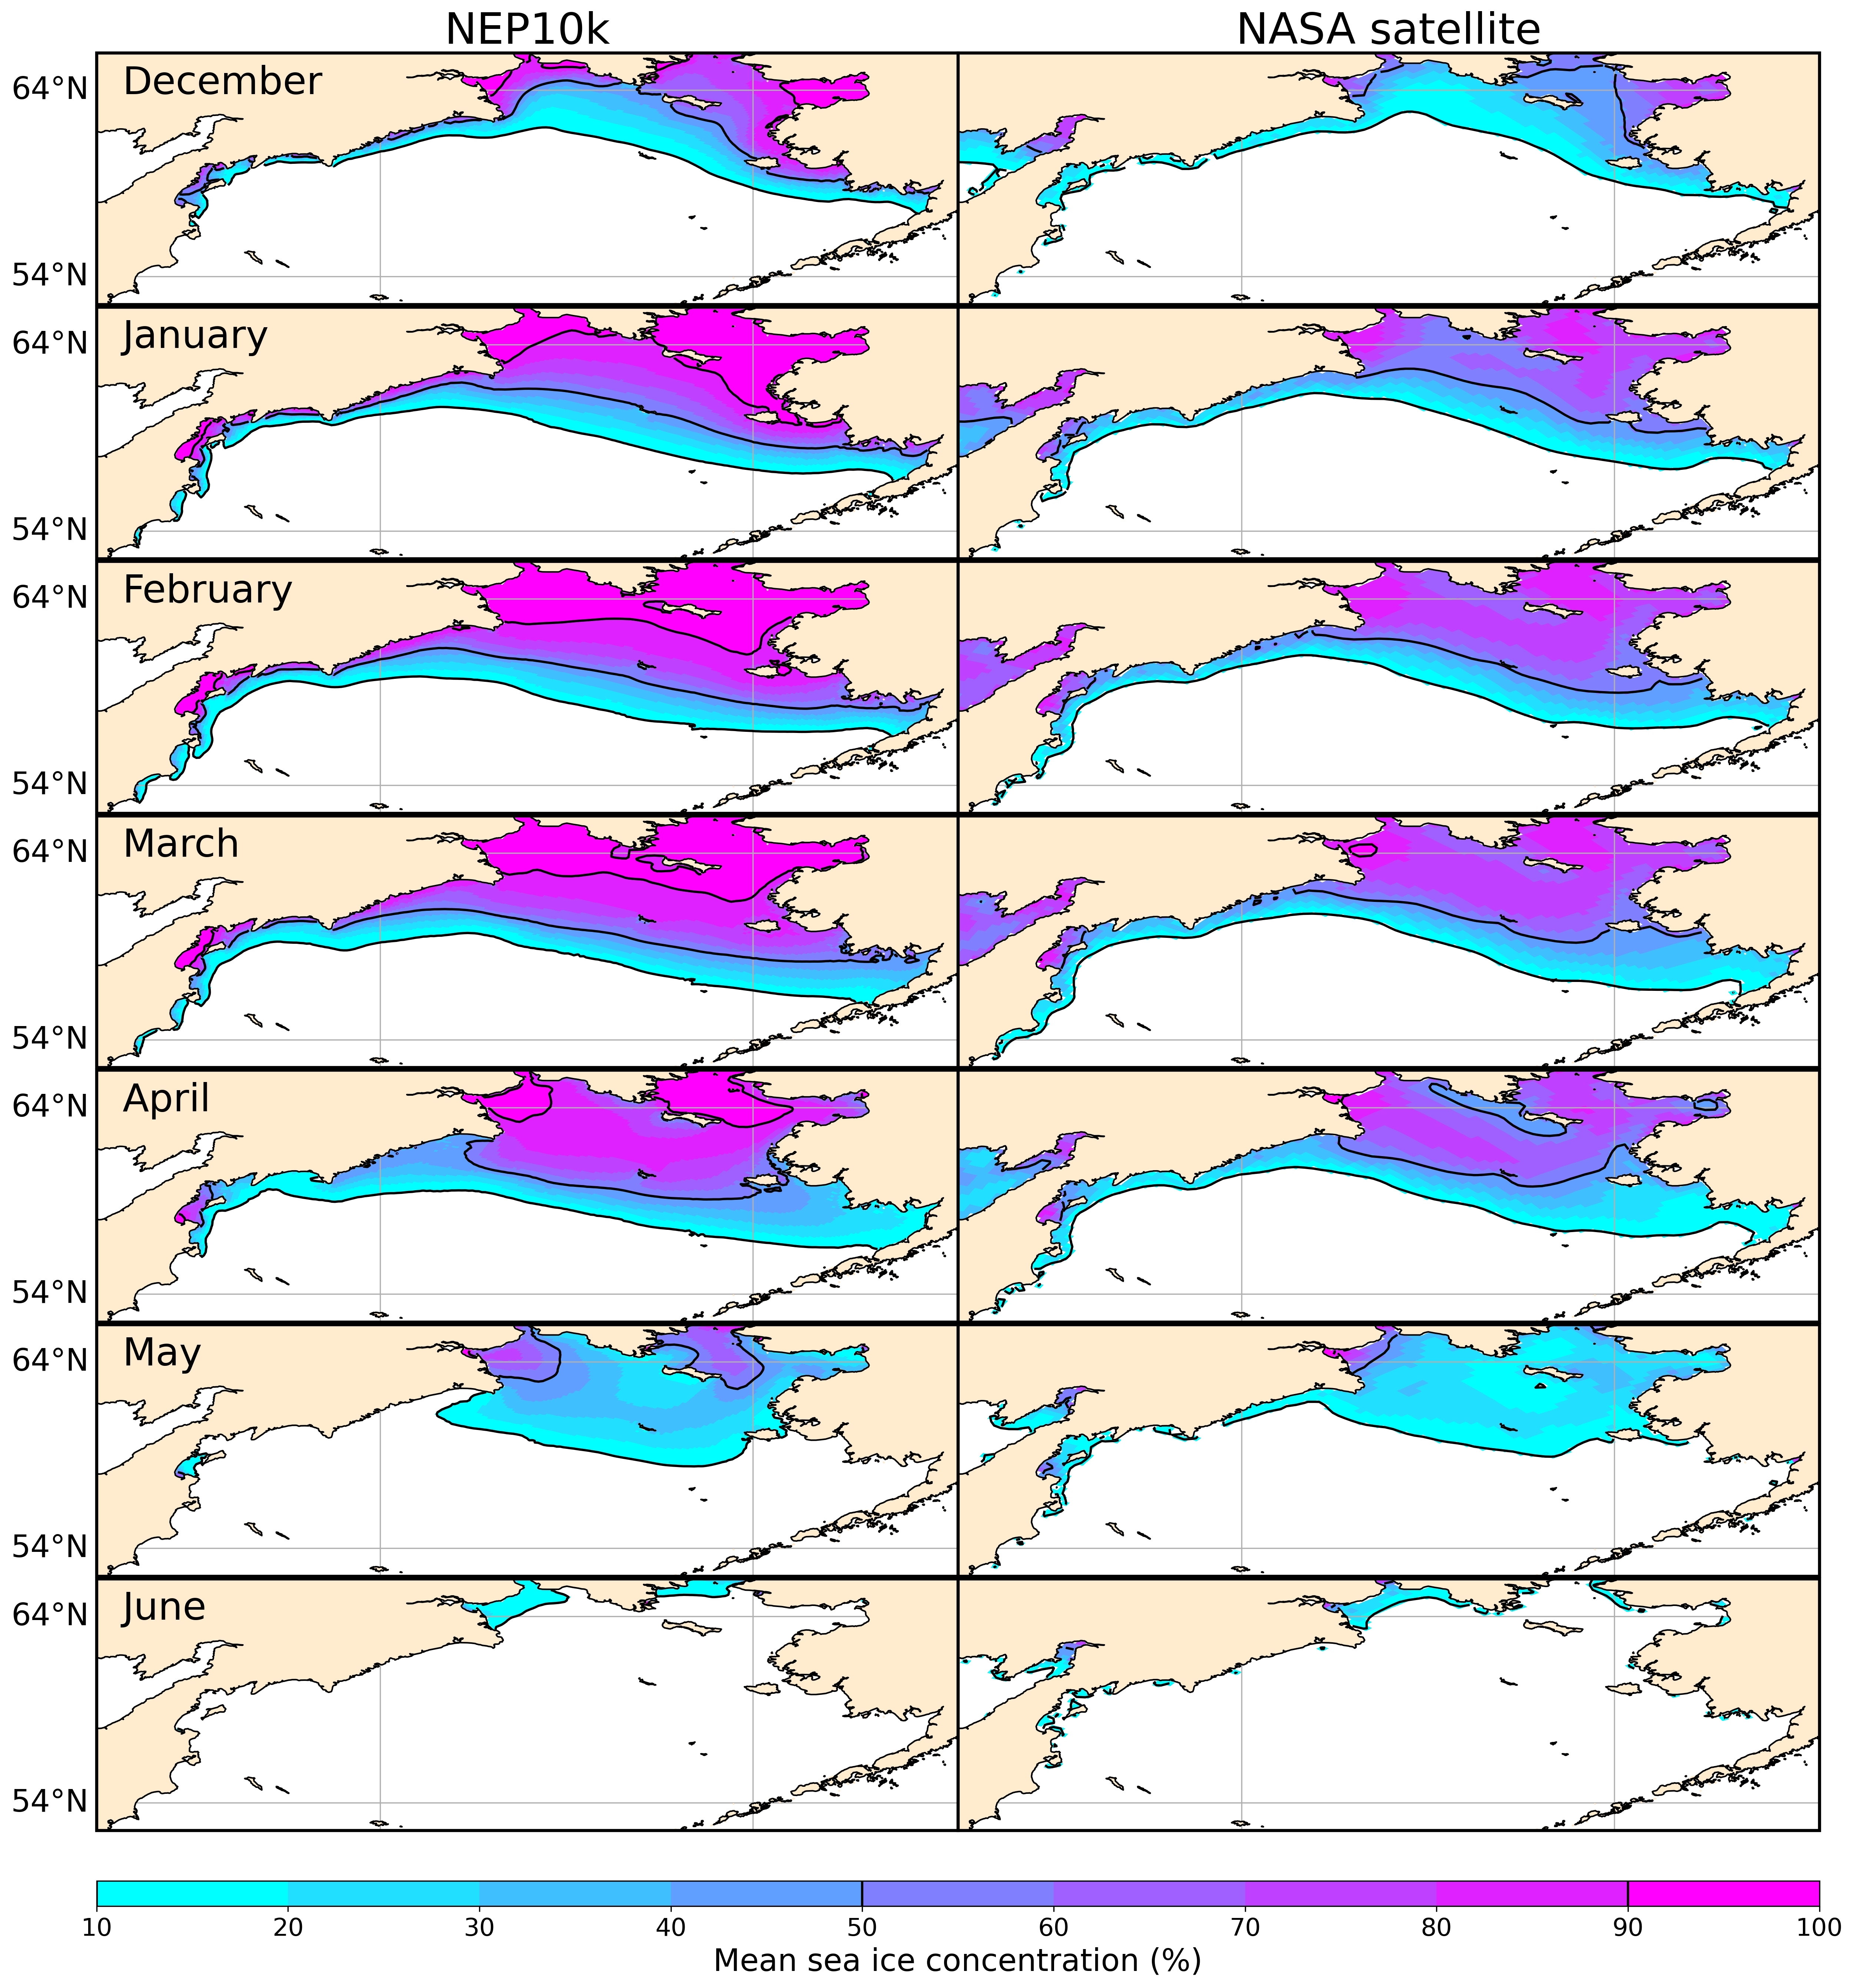

In [6]:
lon_min = 157.8; lon_max = 204 
lat_min = 52.5;  lat_max = 70

levs = [10,50,90]

proj = ccrs.PlateCarree(central_longitude=((lon_max+lon_min)/2)-360)
cmap, norm = get_map_norm('cool', np.arange(10, 101, 10), no_offset=True)

#widths = [10,10,.1,10]
widths = [10,10]
fig = plt.figure(figsize=(20,20.8),dpi=300)
#spec = fig.add_gridspec(ncols=4, nrows=7,wspace=0,hspace=0.,width_ratios=widths)
spec = fig.add_gridspec(ncols=2, nrows=7,wspace=0,hspace=0.)
nlab = 0

for nrow, m in enumerate([12, 1, 2, 3, 4, 5, 6]):
    
    plot_map(0,nep_clon, nep_clat, nep_lon, nep_lat, model_conc.sel(month=m).values*100,'NEP10k')
    nlab+=1
    
    plot_map(1,obs_lon, obs_lat, obs_lon, obs_lat, obs_conc.sel(month=m),'NASA satellite')
    nlab+=1   

plt.savefig('Figure21_nep_satellite_sea_ice')